In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.insert(1,'../data_utils/')
from Sample import Sample 
from HiCDataset import HiCDataset
from HiCMap import HiCMap
sys.path.insert(2,'../diffusion/')
from classifier_free_guidance_greg import Unet, GaussianDiffusion

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /state/partition1/slurm_tmp/24858591.0.0/tmpxqmqke4r
INFO:torch.distributed.nn.jit.instantiator:Writing /state/partition1/slurm_tmp/24858591.0.0/tmpxqmqke4r/_remote_module_non_scriptable.py
2024-01-26 10:18:34.249893: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
chrom = '1' 
region_idx = 330#200#144
nbeads = 64
embeddings_nbeads = 65 
sample_directory = '/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/samples/origami_final_embeddings/'
cond_scales = [0.5,1.,2.,3.,4.,5.]
rescaled_phis = [0.,.25,.5,.75,1.]

In [3]:
exp_hic = HiCDataset()

In [4]:
#emb_fp = lambda chrom: f'/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/embeddings/chrom_{chrom}.tar.gz'
emb_fp = lambda chrom: f'/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/embeddings_{embeddings_nbeads}/chrom_{chrom}.tar.gz'
embeddings = pd.read_pickle(emb_fp(chrom))

In [5]:
#######################
# If new samples should be generated 
consider_generation = False

if consider_generation: 
    embedding_dimensions = (1,260,256)
    milestone = 120
    #fp = f'./results_small/model-{milestone}.pt'
    fp = f'../../data/models/diffusion_small/model-{milestone}.pt'
    
    num_beads = 65
    two_channels = False
    
    c,image_size = 1+int(two_channels), num_beads-1
    model = Unet(
        dim=64,
        #num_classes,
        cond_drop_prob = 0.5,
        init_dim = None,
        out_dim = None,
        dim_mults=(1, 2, 4, 8),
        channels = c,
        resnet_block_groups = 8,
        learned_variance = False,
        learned_sinusoidal_cond = False,
        random_fourier_features = False,
        learned_sinusoidal_dim = 16,
        attn_dim_head = 32,
        attn_heads = 4,
        embedding_dimensions=embedding_dimensions
    )
    
    diffusion = GaussianDiffusion(
        model,
        image_size=image_size,
        timesteps = 1000,
        sampling_timesteps = None,
        objective = 'pred_noise',
        beta_schedule = 'cosine',
        ddim_sampling_eta = 1.,
        offset_noise_strength = 0.,
        min_snr_loss_weight = False,
        min_snr_gamma = 5
    )
    
    try: 
        diffusion.to('cuda')
    except:
        pass
    
    diffusion.load(fp)

    def generate_new_sample(
        region_idx,
        nconfigs=1000,
        cond_scale=1.,
        rescaled_phi=.7,
        embeddings=embeddings,
        diffusion=diffusion
    ):
        
        emb = embeddings.iloc[region_idx,0].to(diffusion.device).expand(nconfigs,-1,-1,-1)
        
        sample = Sample(
            data = diffusion.sample(emb,cond_scale=cond_scale,rescaled_phi=rescaled_phi)
        )
        #sample.to('cpu')
        #pickle.dump(sample,open(f'./sampling_small/sample_{region_idx}_{int(cond_scale)}_{int(10*rescaled_phi)}_{milestone}_{chrom}.pkl','wb'))

        return sample 

In [6]:
def load_sample(
    directory=sample_directory, #'/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/code/diffusion_v1/sampling_small/',
    region_idx=0,
    cond_scale=1.,
    rescaled_phi=.7,
    milestone=69,
    chrom=1
):
    if directory != '' and directory[-1] != '/':
        directory+= '/'
        
    fp = f'{directory}sample_{region_idx}_{int(cond_scale)}_{int(10*rescaled_phi)}_{milestone}_{chrom}.pkl'

    data = pd.read_pickle(fp).unflatten()
    if len(data.shape) == 2: 
        data = data.unsqueeze(0)
    #if len(data.shape) == 3:
    #    data = data.unsqueeze(1)

    return Sample(data=data)
    #return pd.read_pickle(fp)
    #return Sample(data=pd.read_pickle(fp).batch)
    


In [7]:
def get_exp_map(region_idx,exp_hic=exp_hic,emb_idx=embeddings.index,interp_nans=True,region_length=nbeads*20_000):#None): 

    # Get the region information from the embedding index used during sample generation
    region_length1, chrom, start = emb_idx[region_idx]
    region_length = region_length1 if region_length is None else region_length
    stop = start + region_length
    
    return exp_hic.fetch(chrom=chrom,start=start,stop=stop,interp_nans=interp_nans)

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f911c124340>)

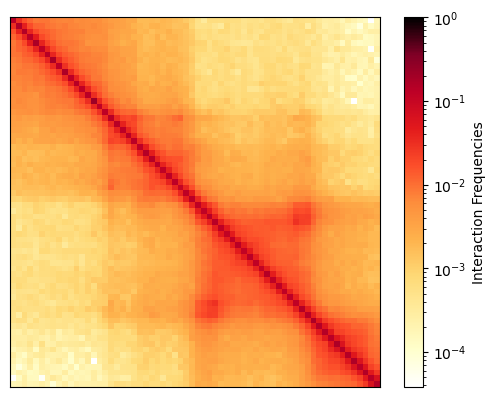

In [8]:
exp_probs = get_exp_map(region_idx)
# Interesting possibles: 265, 330!, 395, 525?, 
exp_probs.plot()

Load the generated samples

In [49]:
sample = load_sample(
    region_idx=region_idx,
    cond_scale=1.,#2.,#1.,
    rescaled_phi=0.,#.5,#0.,
    milestone=120,
    chrom = chrom
)

DON'T correct the distance maps before computing probabilities. Need a special function for that

In [50]:
def tanh_map(sample,r_c,sigma):
    '''
    Avoids using the distance correction approach
    '''
    if sample.normalized: 
        sample.unnormalize_()
    r = sample.unflatten()

    mask = r < r_c 
    r[mask] = .5*( 1 + torch.tanh( sigma*( r_c - r[mask] ) ) )
    mask^= True
    r[mask] = .5 * ( r_c / r[mask] )**4
    
    return HiCMap(r.mean(0).squeeze(),includes_self_interaction=False)

In [51]:
# Get the best r_c & sigma values

r_cs = torch.arange(1,2.5,.01)
sigmas = torch.arange(.5,6,.1)
N = len(r_cs) * len(sigmas)
n=0

best_pcc = -2
r_c = -1
sigma = -1
for r_c_ in r_cs:
    for sigma_ in sigmas:
        probs = tanh_map(sample,r_c_,sigma_)
        pcc = probs.pcc(exp_probs)
        if pcc > best_pcc: 
            best_pcc = pcc
            r_c = r_c_
            sigma = sigma_
        n+=1 
        if n % 250 == 0:
            print(f'{n/N*100}% complete')
print(f'Best PCC: {best_pcc}')
print(f'Best r_c: {r_c}')
print(f'Best sigma: {sigma}')

3.0303030303030303% complete
6.0606060606060606% complete
9.090909090909092% complete
12.121212121212121% complete
15.151515151515152% complete
18.181818181818183% complete
21.21212121212121% complete
24.242424242424242% complete
27.27272727272727% complete
30.303030303030305% complete
33.33333333333333% complete
36.36363636363637% complete
39.39393939393939% complete
42.42424242424242% complete
45.45454545454545% complete
48.484848484848484% complete
51.515151515151516% complete
54.54545454545454% complete
57.57575757575758% complete
60.60606060606061% complete
63.63636363636363% complete
66.66666666666666% complete
69.6969696969697% complete
72.72727272727273% complete
75.75757575757575% complete
78.78787878787878% complete
81.81818181818183% complete
84.84848484848484% complete
87.87878787878788% complete
90.9090909090909% complete
93.93939393939394% complete
96.96969696969697% complete
100.0% complete
Best PCC: 0.8160929713633461
Best r_c: 1.5699999332427979
Best sigma: 2.199999809

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f91178aff70>)

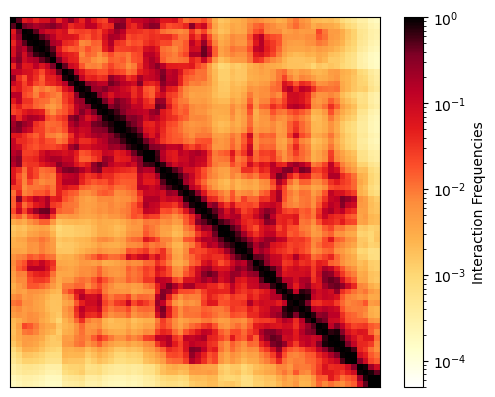

In [57]:
gen_probs_uncorrected = tanh_map(sample,r_c,sigma)
gen_probs_uncorrected.plot(vmin=5e-5)

Correct the distance maps before computing probabilities

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f911bbddcc0>)

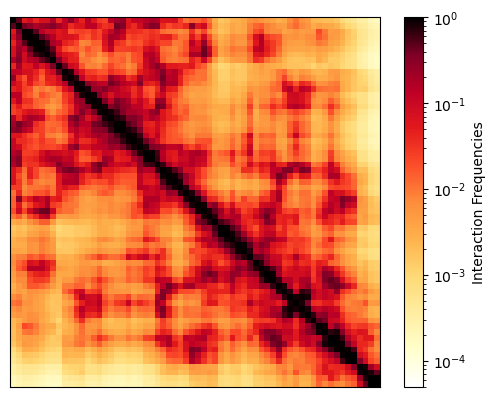

In [53]:
gen_probs = sample.contact_probabilities(r_c=r_c,sigma=sigma)
gen_probs.plot(vmin=5e-5)

Compare them!

In [54]:
# Corrected vs uncorrected generated maps
gen_probs.pcc(gen_probs_uncorrected)

tensor(0.9600, dtype=torch.float64)

In [55]:
# Corrected vs experimental map
gen_probs.pcc(exp_probs)

tensor(0.8145, dtype=torch.float64)

In [56]:
# Uncororrected vs experimental map
gen_probs_uncorrected.pcc(exp_probs)

tensor(0.7892, dtype=torch.float64)

In [69]:
sample = load_sample(
    region_idx=region_idx,
    cond_scale=1.,#2.,#1.,
    rescaled_phi=0.,#.5,#0.,
    milestone=120,
    chrom = chrom
)

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f9116d7ba90>)

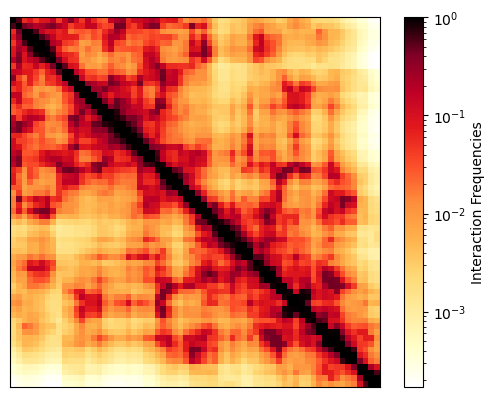

In [70]:
temp = tanh_map(sample,1.6,6)#r_c,sigma)
temp.plot()#vmin=5e-5)

In [71]:
temp.pcc(exp_probs)

tensor(0.8112, dtype=torch.float64)

Now scan over many rescaled phi/cond scale values

In [32]:
pccs = []
scales = []
phis = []
best_pcc = -2
best_scale = -1
best_phi = -1
for cond_scale in cond_scales: 
    for rescaled_phi in rescaled_phis: 
        try: 
            sample = load_sample(
                region_idx=region_idx,
                cond_scale=cond_scale,
                rescaled_phi=rescaled_phi,
                milestone=120,
                chrom = chrom
            )
        except:
            if n % 10 == 0:
                print(f'{n/N*100}% completed')
                print(f'Best PCC so far: {best_pcc}')
                print('')
            continue
        temp_probs = tanh_map(sample,r_c,sigma)
        pccs.append(temp_probs.pcc(exp_probs))
        scales.append(cond_scale)
        phis.append(rescaled_phi)
        if pccs[-1] > best_pcc:
            best_pcc = pccs[-1]
            best_scale = cond_scale
            best_phi = rescaled_phi

print(f'Best PCC:\t{best_pcc}')
print(f'Best Scale:\t{best_scale}')
print(f'Best Rescale:\t{best_phi}')

100.0% completed
Best PCC so far: 0.9361833097452978

100.0% completed
Best PCC so far: 0.9361833097452978

100.0% completed
Best PCC so far: 0.9361833097452978

100.0% completed
Best PCC so far: 0.9361833097452978

Best PCC:	0.9361833097452978
Best Scale:	0.5
Best Rescale:	1.0


In [ ]:
pccs

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f911ba3ace0>)

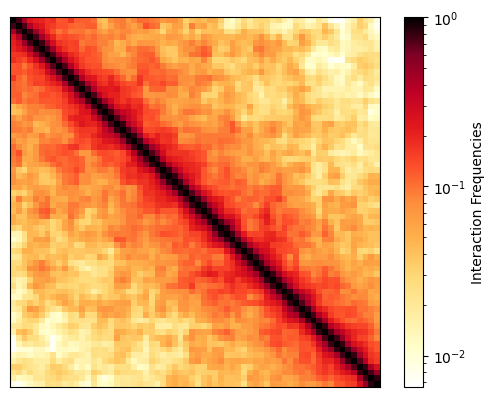

In [33]:
sample = load_sample(
    region_idx=region_idx,
    cond_scale=best_scale,
    rescaled_phi=best_phi,
    milestone=120,
    chrom = chrom
)
gen_probs_uncorrected = tanh_map(sample,r_c,sigma)
gen_probs_uncorrected.plot()

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f91185b6d70>)

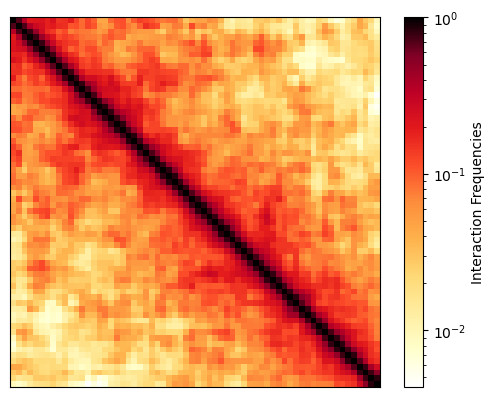

In [34]:
gen_probs = sample.contact_probabilities(r_c=r_c,sigma=sigma)
gen_probs.plot()

In [35]:
gen_probs.pcc(gen_probs_uncorrected)

tensor(0.9951, dtype=torch.float64)

In [36]:
gen_probs.pcc(exp_probs)

tensor(0.9306, dtype=torch.float64)

In [37]:
gen_probs_uncorrected.pcc(exp_probs)

tensor(0.9362, dtype=torch.float64)

In [38]:
# Get the best r_c & sigma values

r_cs = torch.arange(1,2.5,.01)
sigmas = torch.arange(.5,6,.1)
N = len(r_cs) * len(sigmas)
n=0

best_pcc = -2
r_c = -1
sigma = -1
for r_c_ in r_cs:
    for sigma_ in sigmas:
        probs = tanh_map(sample,r_c_,sigma_)
        pcc = probs.pcc(exp_probs)
        if pcc > best_pcc: 
            best_pcc = pcc
            r_c = r_c_
            sigma = sigma_
        n+=1 
        if n % 250 == 0:
            print(f'{n/N*100}% complete')
print(f'Best PCC: {best_pcc}')
print(f'Best r_c: {r_c}')
print(f'Best sigma: {sigma}')

3.0303030303030303% complete
6.0606060606060606% complete
9.090909090909092% complete
12.121212121212121% complete
15.151515151515152% complete
18.181818181818183% complete
21.21212121212121% complete
24.242424242424242% complete
27.27272727272727% complete


KeyboardInterrupt: 

In [ ]:
asdf

In [10]:
new_sample = generate_new_sample(region_idx)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
new_gen_probs = new_sample.contact_probabilities()

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f493ded4460>)

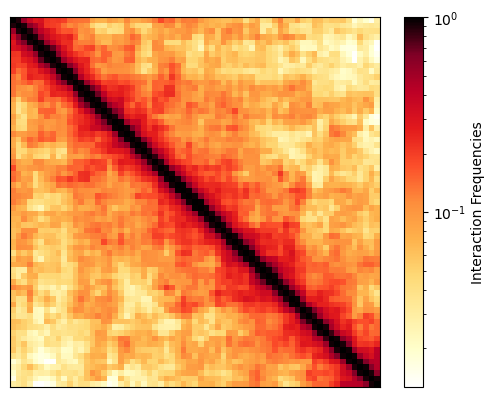

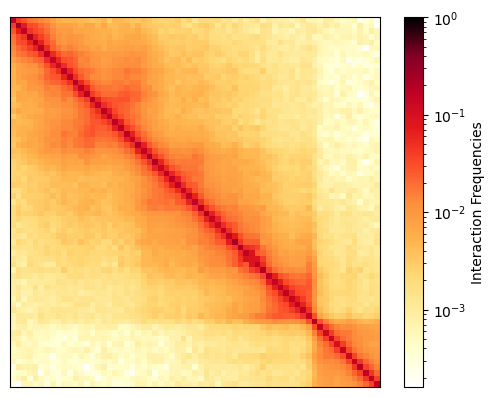

In [13]:
new_gen_probs.plot()
exp_probs.plot()

In [22]:
import torch
r_cs = torch.arange(1,3.01,.01)
sigmas = torch.arange(.5,8,.25)
pccs = torch.empty(len(r_cs),len(sigmas),dtype=torch.double)
for i,r_c in enumerate(r_cs): 
    for j,sigma in enumerate(sigmas):
        pp = new_sample.contact_probabilities(r_c=r_c,sigma=sigma)
        pccs[i,j] = pp.pcc(exp_probs).cpu()

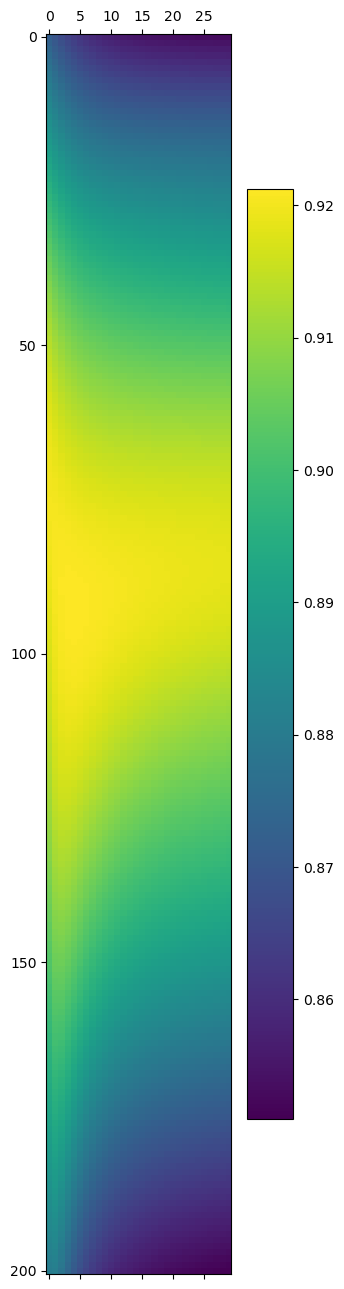

In [23]:
plt.matshow(pccs.cpu().numpy())
plt.colorbar()

In [27]:
pccs = pccs.cpu().numpy()
pccs.max()

0.9212660348374146

In [35]:
import numpy as np
i,j = np.where(pccs == pccs.max())
best_r_c = float(r_cs[i])
best_sigma = float(sigmas[j])

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f493671bbe0>)

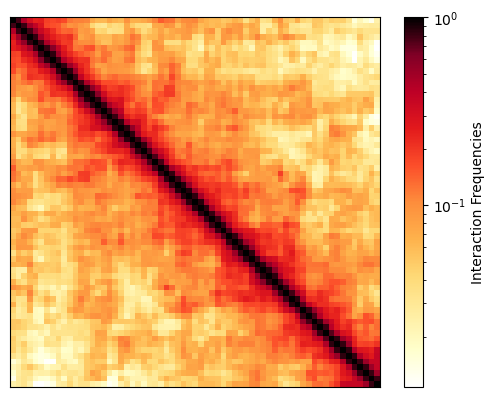

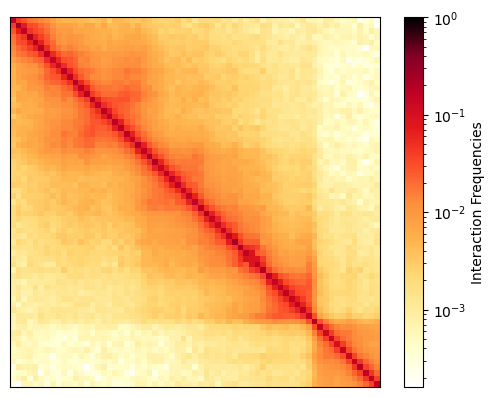

In [37]:
new_gen_probs = new_sample.contact_probabilities(r_c=best_r_c,sigma=best_sigma)
new_gen_probs.plot()
exp_probs.plot()

In [15]:
#import pickle
#pickle.dump(new_sample,open('first_sample.pkl','wb'))